# Let's apply the GP-based optimizer to our small Hubbard model.

Make sure your jupyter path is the same as your virtual environment that you used to install all your packages. 
If nopt, do something like this in your terminal:

`$ ipython kernel install --user --name TUTORIAL --display-name "Python 3.9"`

In [1]:
# check your python
from platform import python_version

print(python_version())

3.8.12


Gaussian Process (GP) models were introduced in the __[Gaussian Process Models](optimization.ipynb)__ notebook. The GP-based optimizer uses these techniques as implemented in the included __[opti_by_gp.py](opti_by_gp.py)__ module, which also provides helpers for plotting results. Note that this module uses the ImFil optimizer underneath, a choice that can not currently be changed.

As a first step, create once more a __[Hubbard Model](hubbard_model_intro.ipynb)__ setup.

In [2]:
import hubbard as hb
import logging
import noise_model as noise
import numpy as np
import opti_by_gp as obg
from IPython.display import Image

logging.getLogger('hubbard').setLevel(logging.INFO)

In [3]:
# Select a model appropriate for the machine used:
#    laptop -> use small model
#    server -> use medium model

MODEL = hb.small_model
#MODEL = hb.medium_model

# Hubbard model for fermions (Fermi-Hubbard) required parameters
xdim, ydim, t, U, chem, magf, periodic, spinless = MODEL()

# Number of electrons to add to the system
n_electrons_up   = 1
n_electrons_down = 1
n_electrons = n_electrons_up + n_electrons_down

# Total number of "sites", with each qubit representing occupied or not
spinfactor = spinless and 1 or 2
n_qubits = n_sites = xdim * ydim * spinfactor

# Create the Hubbard Model for use with Qiskit
hubbard_op = hb.hamiltonian_qiskit(
    x_dimension        = xdim,
    y_dimension        = ydim,
    tunneling          = t,
    coulomb            = U,
    chemical_potential = chem,
    magnetic_field     = magf,
    periodic           = periodic,
    spinless           = spinless)

In [ ]:
def res_energy(result):
    try:
        return result.fun
    except AttributeError:
        return result[1]

def res_nevals(result):
    try:
        return result.nfev
    except AttributeError:
        return result[2]

def res_x(result):
    try:
        return result.x
    except AttributeError:
        return result[0]

The GP modeling needs persistent access to the evaluated points, so tell the objective to save them. Otherwise, the objective is the same as before. Choose the maximum number of objective evaluations, the initial and set the bounds. Then run the optimization using GP (as mentioned before, this uses ImFil underneath).

In [4]:
# noise-free objective with enough Trotter steps to get an accurate result
objective = hb.EnergyObjective(hubbard_op, n_electrons_up, n_electrons_down,
    trotter_steps=3, save_evals=True)

# initial and bounds (set good=True to get tighter bounds)
initial_amplitudes, bounds = MODEL.initial(
    n_electrons_up, n_electrons_down, objective.npar(), good=False)

# max number of allowed function evals
maxevals = 100

[-1. -1.] [1. 1.]
hubbard                |     INFO - objective: 2.07393 @ [0.05085771 0.26232159]
hubbard                |     INFO - objective: 2.69113 @ [ 0.4540621  -0.50305256]
hubbard                |     INFO - objective: 1.33268 @ [-0.39073646  0.46827345]
hubbard                |     INFO - objective: -0.86014 @ [-0.70438334 -0.04232066]
hubbard                |     INFO - objective: -0.17493 @ [0.86199183 0.70236303]
hubbard                |     INFO - objective: 1.99930 @ [-0.04784765 -0.85364807]
xnew: [[-0.93499462 -0.11781186]]
hubbard                |     INFO - objective: -0.35797 @ [-0.93499462 -0.11781186]
energy -0.35797012722738
bestX:  [[-0.70438334 -0.04232066]]
bestY:  [[-0.8601437]]
Nevals:  7
xnew: [[0.58906885 1.        ]]
hubbard                |     INFO - objective: -1.15589 @ [0.58906885 1.        ]
energy -1.1558923061057644
bestX:  [[0.58906885 1.        ]]
bestY:  [[-1.15589231]]
Nevals:  8
xnew: [[-0.6233366  -0.34125275]]
hubbard                |     

hubbard                |     INFO - objective: -1.21896 @ [-0.90711861  0.17920897]
hubbard                |     INFO - objective: -1.23098 @ [-0.89240226  0.19205026]
hubbard                |     INFO - objective: -1.23354 @ [-0.88504408  0.19847091]
hubbard                |     INFO - objective: -1.23274 @ [-0.8698734   0.20489155]
hubbard                |     INFO - objective: -1.23287 @ [-0.8776859   0.21270405]
hubbard                |     INFO - objective: -1.23383 @ [-0.8854984   0.20489155]
hubbard                |     INFO - objective: -1.23382 @ [-0.8776859   0.19707905]
number evals remaining 34
ImFil trial number:  0 , result:  (array([-0.8854984 ,  0.20489155]), -1.2338277068376264, 36)
estimated energy: -1.23383
parameters:       [-0.8854984   0.20489155]
found improvement!
best energy so far:  -1.2338277068376264
best parameters so far:  [-0.8854984   0.20489155]
initial guess:  [[0.66457858 1.        ]]
hubbard                |     INFO - objective: -1.15881 @ [0.664578

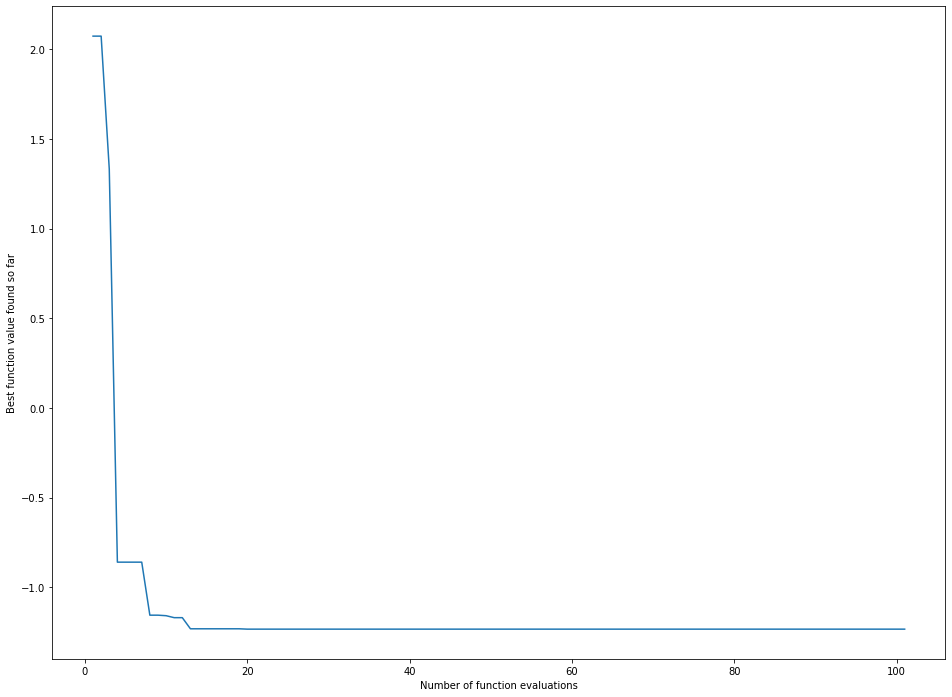

In [5]:
result = obg.opti_by_gp(objective.npar(), bounds, objective, maxevals)

In [6]:
print('Results with GP:')
print("Estimated energy: %.5f" % result[1])
print("Parameters:      ", result[0])
print("Number of iters: ", result[2])

Results with GP:
Estimated energy: -1.23383
Parameters:       [-0.8854984   0.20489155]
Number of iters:  101


Now let's analyze the results be looking at the sample evaluations and convergence plot.

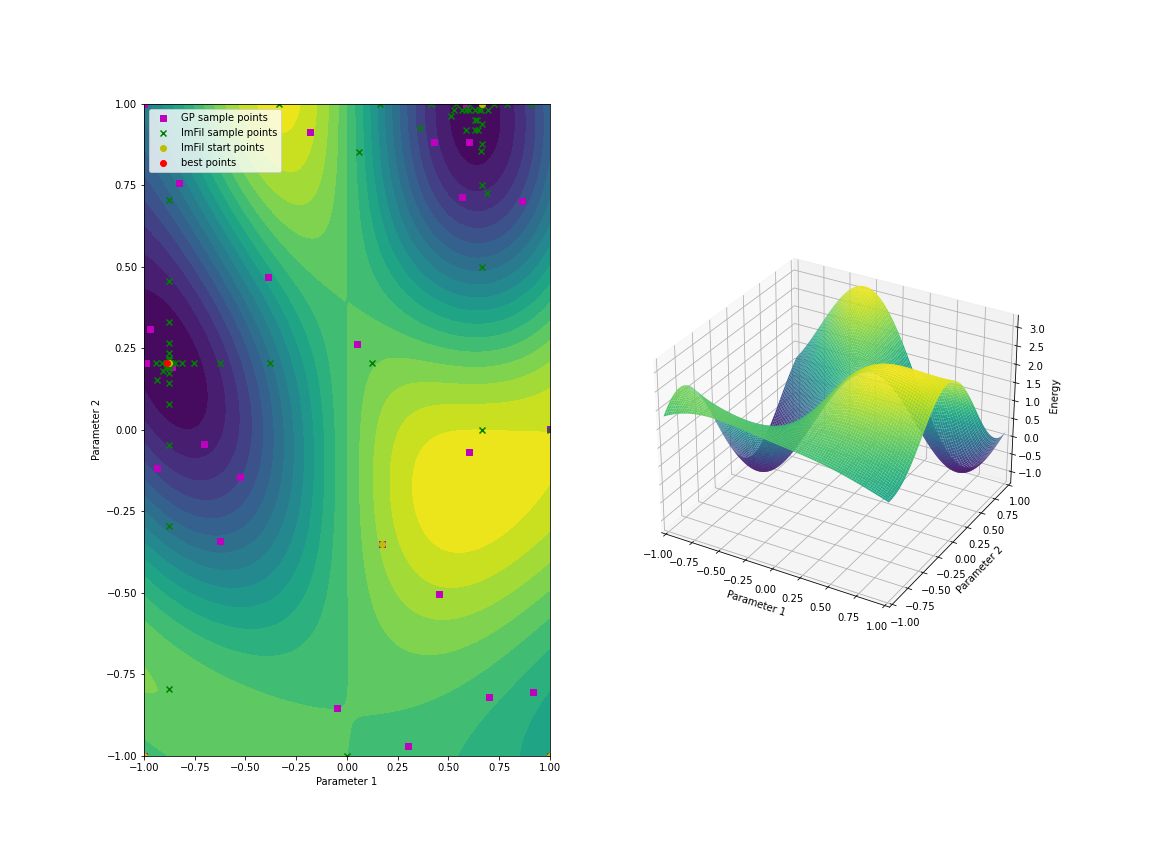

In [7]:
Image(filename='samples.png')

The left plot shows:
1) the points sampled with GP (pink squares): you can see that we have some points everywhere in the space, but a denser pink square cloud where the function has its minimum

2) yellow circles (5) -- these are the points from which the local search with ImFil starts: we choose the best point found by the GP, and another 4 points based on their function value and distance to already selected start points. 5 is a parameter, if you want to do only one local search, you can just start from the best point found by the GP iterations. Also: not all 5 points will necessarily be used for ImFil, the optimization stops when the maximum number of allowed evaluations has been reached. 

3) the green squares are the points ImFil decided to sample -- you can see that they cover most of the space. Wouldn't it be nice to force ImFil to search only a smaller radius?!

4) the red dot indicates the best point found during optimization

5) the contours are created by using a GP model and all sample information that we collected - so this is not the true contours, but the best guess of what the true contours may look like

The right plot shows the GP approximation of the energy surface - again, not the true surface, just our best guess based on training a GP on all input-output pairs

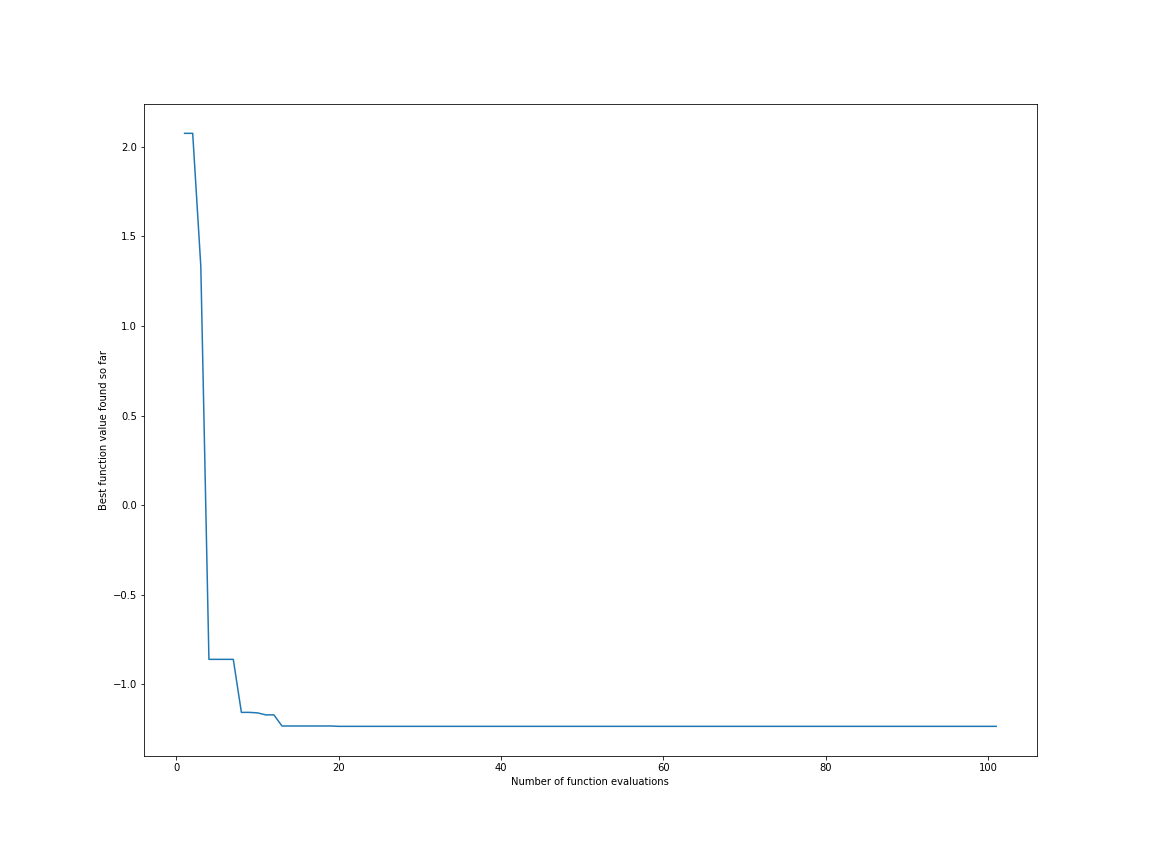

In [8]:
Image(filename='progress.png')

This plot shows the progress we are making with respect to improving the energy versus the number of function evaluations. 
We show the best energy value found so far, thus, the graph is monotonically decreasing and has a step-like shape. whenever the graph is flat, it means that during these iterations no energy improvements were found. If you were to plot simply the energy at each function evaluation, the graph would go up and down because we use sampling based algorithms and not gradient-based algorithms. Thus, not in every iteration we find an improvement. 
There is a large down-step in the beginning - this is due to our random space filling sampling initially. We can also see that ImFil does not make much progress here. The GP-based sampling is used until 30 evaluations. 

Note that the GP based optimizer has parameters, including the size of the initial experimental design, the number of iterations that we want to apply the GP (here 30), the maximum number of local searches with ImFil after the GP is done, .... see the __[opti_by_gp.py](opti_by_gp.py)__ module (or run the cell below to load).

In [ ]:
%load 'opti_by_gp.py'

**Exercise:** redo the above analysis using a noisy objective. If time is limited, consider only using sampling noise, e.g. by setting `shots=8192` (see the notebook on __[noise](hubbard_vqe_noise.ipynb)__ for more examples), and using tight bounds.

**Optional Exercise:** for comparison purposes, follow-up with an optimization run that does not use GP and try in particular what happens when using only few function evaluations (20, say, if using tight bounds). Try different optimizers (but consider that some, such as SPSA, will take more evalations per iteration; and consider that optimizers that do not respect bounds are at a severe disadvantage).

In [10]:
# noisy objective, adjust as desired
objective = hb.EnergyObjective(hubbard_op, n_electrons_up, n_electrons_down,
    trotter_steps=3, shots=8192, save_evals=True)

# initial and bounds (set good=False to get loose bounds)
initial_amplitudes, bounds = MODEL.initial(
    n_electrons_up, n_electrons_down, objective.npar(), good=True)

# max number of allowed function evals
maxevals = 20

[0.5 0.8] [0.7 1. ]
hubbard                |     INFO - objective: -1.13000 @ [0.55140364 0.95930822]
hubbard                |     INFO - objective: -1.16138 @ [0.68782594 0.99678022]
hubbard                |     INFO - objective: -1.03857 @ [0.53032341 0.91189341]
hubbard                |     INFO - objective: -1.11975 @ [0.60925348 0.89478702]
hubbard                |     INFO - objective: -1.05664 @ [0.64248457 0.83892419]
hubbard                |     INFO - objective: -0.98901 @ [0.58012936 0.83230062]
xnew: [[0.64395353 0.99276341]]
hubbard                |     INFO - objective: -1.16162 @ [0.64395353 0.99276341]
energy -1.16162109375
bestX:  [[0.64395353 0.99276341]]
bestY:  [[-1.16162109]]
Nevals:  7
xnew: [[0.65049935 0.96825251]]
hubbard                |     INFO - objective: -1.18469 @ [0.65049935 0.96825251]
energy -1.1846923828125
bestX:  [[0.65049935 0.96825251]]
bestY:  [[-1.18469238]]
Nevals:  8
xnew: [[0.68729339 0.98647149]]
hubbard                |     INFO - objectiv

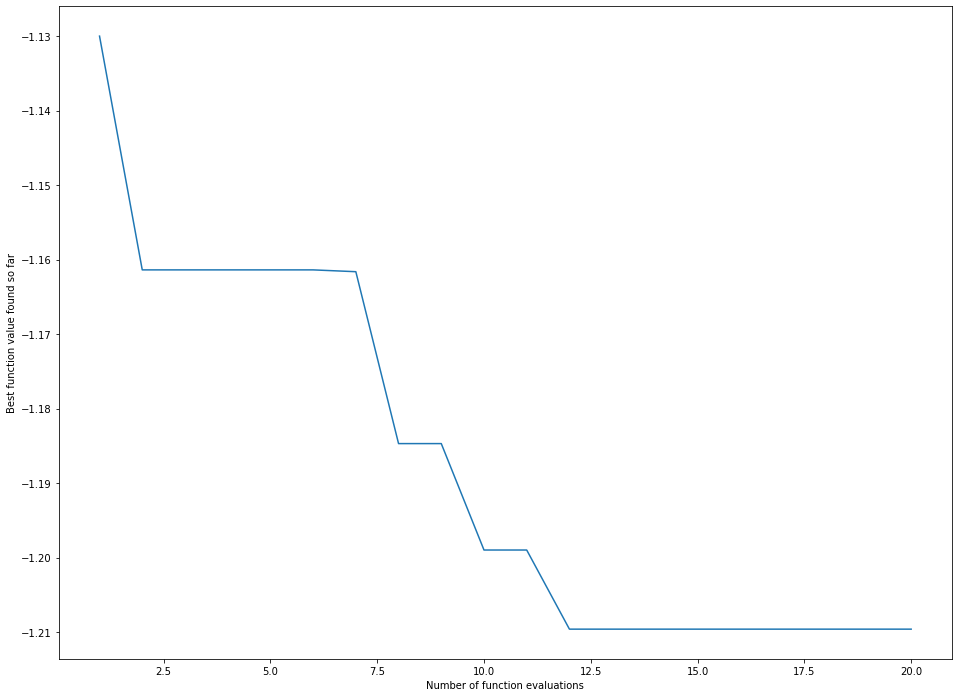

In [11]:
result = obg.opti_by_gp(objective.npar(), bounds, objective, maxevals)

In [12]:
print('Results with GP:')
print("Estimated energy: %.5f" % res_energy(result))
print("Parameters:      ", res_x(result))
print("Number of iters: ", res_nevals(result))

Results with GP:
Estimated energy: -1.20959
Parameters:       [0.63265844 0.95073751]
Number of iters:  20


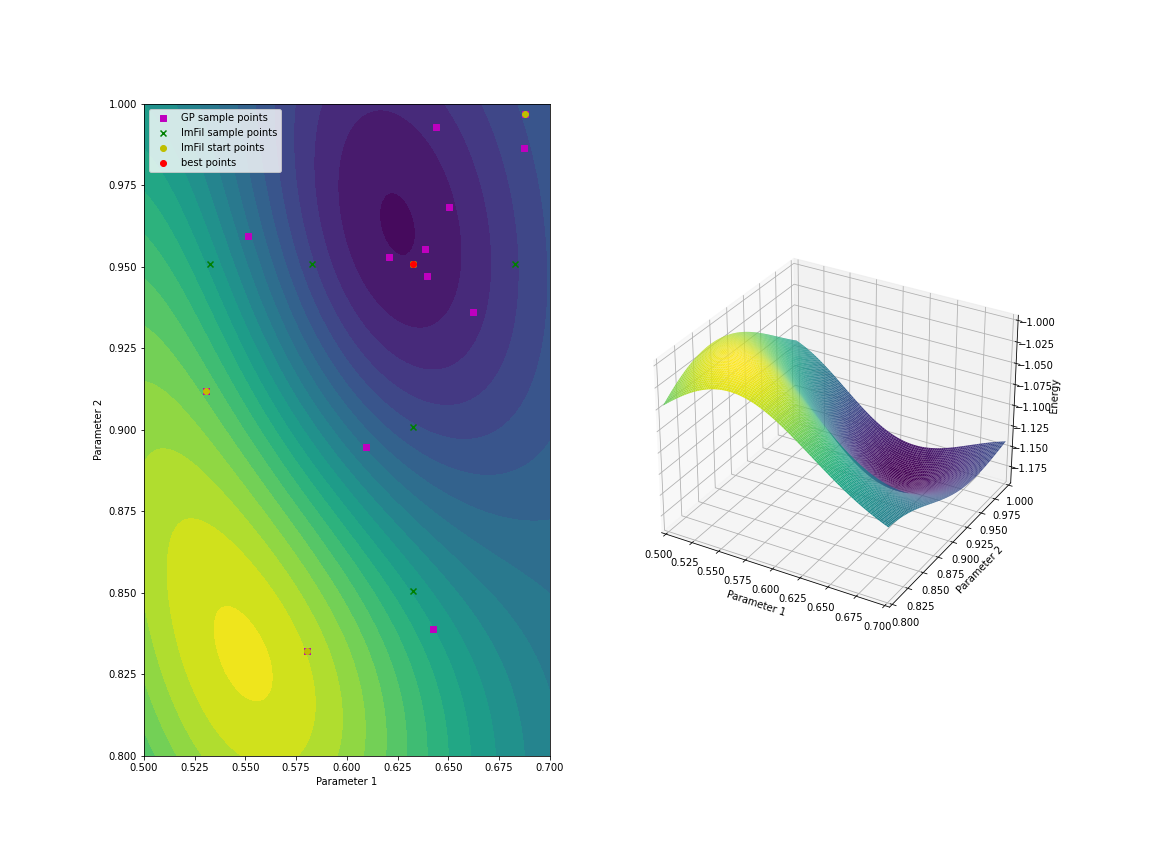

In [13]:
Image(filename='samples.png')

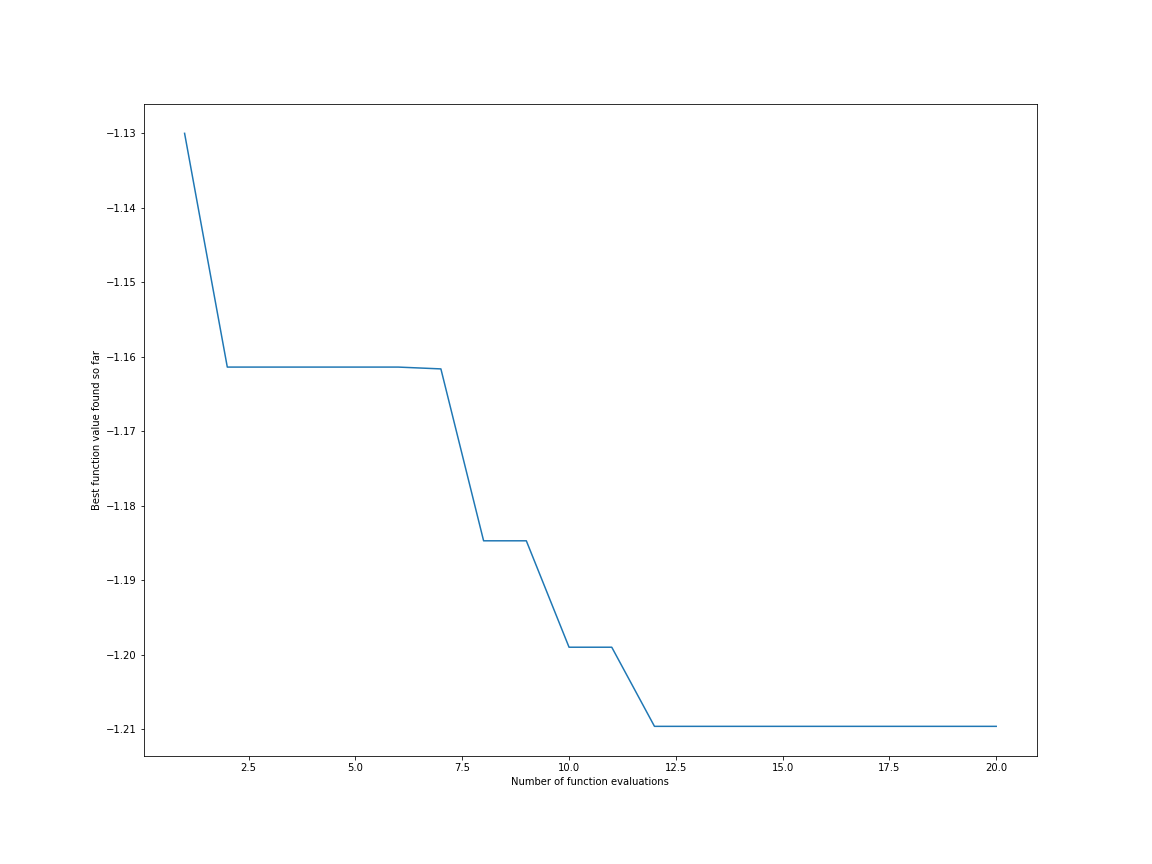

In [14]:
Image(filename='progress.png')

In [15]:
# Pull in a couple of optimizers to play with
from qiskit_algorithms.optimizers import COBYLA, SPSA
try:
    from qiskit_algorithms.optimizers import IMFIL, SNOBFIT
except ImportError:
    print("install scikit-quant to use IMFIL and SNOBFIT")

In [16]:
result = IMFIL(maxiter=maxevals).minimize(objective, initial_amplitudes, bounds=bounds)

hubbard                |     INFO - objective: -1.14734 @ [0.6 0.9]
hubbard                |     INFO - objective: -1.12317 @ [0.7 0.9]
hubbard                |     INFO - objective: -1.17871 @ [0.6 1. ]
hubbard                |     INFO - objective: -0.92639 @ [0.5 0.9]
hubbard                |     INFO - objective: -0.93738 @ [0.6 0.8]
hubbard                |     INFO - objective: -1.17847 @ [0.6285846  0.93505692]
hubbard                |     INFO - objective: -1.05139 @ [0.5285846  0.93505692]
hubbard                |     INFO - objective: -1.02795 @ [0.6285846  0.83505692]
hubbard                |     INFO - objective: -1.16785 @ [0.65 1.  ]
hubbard                |     INFO - objective: -1.13269 @ [0.55 1.  ]
hubbard                |     INFO - objective: -1.17737 @ [0.6  0.95]
hubbard                |     INFO - objective: -1.17688 @ [0.625 1.   ]
hubbard                |     INFO - objective: -1.12463 @ [0.575 1.   ]
hubbard                |     INFO - objective: -1.16455 @ [0

In [17]:
print('ImFil results without GP:')
print("Estimated energy: %.5f" % res_energy(result))
print("Parameters:      ", res_x(result))
print("Number of iters: ", res_nevals(result))

ImFil results without GP:
Estimated energy: -1.19226
Parameters:       [0.6     0.98125]
Number of iters:  21


In [18]:
result = SPSA(maxiter=maxevals//2).minimize(    # note division by 2, but also check actual evals!
    objective, initial_amplitudes, bounds=bounds)

hubbard                |     INFO - objective: -0.66895 @ [0.8 1.1]
hubbard                |     INFO - objective: -0.07520 @ [0.4 0.7]
hubbard                |     INFO - objective: -0.67065 @ [0.8 1.1]
hubbard                |     INFO - objective: -0.04810 @ [0.4 0.7]
hubbard                |     INFO - objective: -0.40894 @ [0.8 0.7]
hubbard                |     INFO - objective: -0.49646 @ [0.4 1.1]
hubbard                |     INFO - objective: -0.05798 @ [0.4 0.7]
hubbard                |     INFO - objective: -0.66101 @ [0.8 1.1]
hubbard                |     INFO - objective: -0.66187 @ [0.8 1.1]
hubbard                |     INFO - objective: -0.05225 @ [0.4 0.7]
hubbard                |     INFO - objective: -0.40417 @ [0.8 0.7]
hubbard                |     INFO - objective: -0.50220 @ [0.4 1.1]
hubbard                |     INFO - objective: -0.07788 @ [0.4 0.7]
hubbard                |     INFO - objective: -0.68750 @ [0.8 1.1]
hubbard                |     INFO - objective: -

In [19]:
print('SPSA results without GP:')
print("Estimated energy: %.5f" % res_energy(result))
print("Parameters:      ", res_x(result))
print("Number of iters: ", res_nevals(result))

SPSA results without GP:
Estimated energy: 0.97375
Parameters:       [2.09525784 1.28526137]
Number of iters:  20
